In [1]:
%pip install transformers torch pandas scikit-learn

%pip install accelerate -U

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
file_path = '../database/TextEmo/text.csv'  
data = pd.read_csv(file_path)

# Preprocess the text (e.g., lowercasing)
data['text'] = data['text'].str.lower()


In [3]:
data

,id,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [4]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text for BERT
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

c:\CodeRepo\DS-Capstone-Spring-2024\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('text_emotion_detection_model')

# Tokenize the text for BERT
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

c:\CodeRepo\DS-Capstone-Spring-2024\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import torch

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets for training, validation, and testing
train_dataset = EmotionDataset(train_encodings, list(train_labels))
val_dataset = EmotionDataset(val_encodings, list(val_labels))
test_dataset = EmotionDataset(test_encodings, list(test_labels))


In [7]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU available, using the CPU instead.")


There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [14]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
model = model.to(device)  # Move the model to the GPU if available


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('text_emotion_detection_model', num_labels=6)
model = model.to(device)  # Move the model to the GPU if available

In [17]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

In [18]:
from transformers import TrainingArguments, Trainer
import logging

# Set logging to warning level to reduce output verbosity
logging.getLogger("transformers").setLevel(logging.WARNING)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
    save_strategy="no",  # No intermediate checkpoints are saved
    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    load_best_model_at_end=False  # Do not load the best model at the end
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


c:\CodeRepo\DS-Capstone-Spring-2024\.venv\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [16]:
trainer.train()

  0%|          | 93/125043 [01:37<36:28:15,  1.05s/it]
                                                     
  0%|          | 126/41681 [06:55<3:42:06,  3.12it/s]  

{'loss': 0.6936, 'grad_norm': 9.939903259277344, 'learning_rate': 4.9392923921225805e-05, 'epoch': 0.02}


                                                     
  0%|          | 126/41681 [14:49<3:42:06,  3.12it/s] 

{'loss': 0.3136, 'grad_norm': 0.04120092839002609, 'learning_rate': 4.8178771763677425e-05, 'epoch': 0.05}


                                                     
  0%|          | 126/41681 [23:31<3:42:06,  3.12it/s] 

{'loss': 0.236, 'grad_norm': 87.50275421142578, 'learning_rate': 4.696461960612904e-05, 'epoch': 0.07}


                                                     
  0%|          | 126/41681 [30:11<3:42:06,  3.12it/s] 

{'loss': 0.2088, 'grad_norm': 3.2730729579925537, 'learning_rate': 4.575046744858066e-05, 'epoch': 0.1}


                                                     
  0%|          | 126/41681 [36:36<3:42:06,  3.12it/s] 

{'loss': 0.1958, 'grad_norm': 0.020223533734679222, 'learning_rate': 4.453631529103228e-05, 'epoch': 0.12}


                                                     
  0%|          | 126/41681 [42:38<3:42:06,  3.12it/s] 

{'loss': 0.1698, 'grad_norm': 1.8930474519729614, 'learning_rate': 4.332216313348389e-05, 'epoch': 0.14}


                                                     
  0%|          | 126/41681 [48:37<3:42:06,  3.12it/s] 

{'loss': 0.1713, 'grad_norm': 0.032749272882938385, 'learning_rate': 4.210801097593551e-05, 'epoch': 0.17}


                                                     
  0%|          | 126/41681 [54:42<3:42:06,  3.12it/s] 

{'loss': 0.1632, 'grad_norm': 9.125213623046875, 'learning_rate': 4.089385881838712e-05, 'epoch': 0.19}


                                                     
  0%|          | 126/41681 [1:00:47<3:42:06,  3.12it/s]

{'loss': 0.1605, 'grad_norm': 3.2477190494537354, 'learning_rate': 3.9679706660838736e-05, 'epoch': 0.22}


                                                       
  0%|          | 126/41681 [1:06:57<3:42:06,  3.12it/s]  

{'loss': 0.1628, 'grad_norm': 0.04816950857639313, 'learning_rate': 3.846555450329035e-05, 'epoch': 0.24}


                                                       
  0%|          | 126/41681 [1:13:09<3:42:06,  3.12it/s]  

{'loss': 0.1549, 'grad_norm': 0.015616790391504765, 'learning_rate': 3.725140234574197e-05, 'epoch': 0.26}


                                                       
  0%|          | 126/41681 [1:19:10<3:42:06,  3.12it/s]  

{'loss': 0.1509, 'grad_norm': 2.3714170455932617, 'learning_rate': 3.603725018819359e-05, 'epoch': 0.29}


                                                       
  0%|          | 126/41681 [1:25:18<3:42:06,  3.12it/s]  

{'loss': 0.1596, 'grad_norm': 0.028019607067108154, 'learning_rate': 3.48230980306452e-05, 'epoch': 0.31}


                                                       
  0%|          | 126/41681 [1:31:30<3:42:06,  3.12it/s]  

{'loss': 0.1518, 'grad_norm': 0.01010742038488388, 'learning_rate': 3.360894587309682e-05, 'epoch': 0.34}


                                                       
  0%|          | 126/41681 [1:37:39<3:42:06,  3.12it/s]  

{'loss': 0.1377, 'grad_norm': 1.0553841590881348, 'learning_rate': 3.2394793715548434e-05, 'epoch': 0.36}


                                                       
  0%|          | 126/41681 [1:43:48<3:42:06,  3.12it/s]  

{'loss': 0.1376, 'grad_norm': 3.7261879444122314, 'learning_rate': 3.1180641558000054e-05, 'epoch': 0.38}


                                                       
  0%|          | 126/41681 [1:50:03<3:42:06,  3.12it/s]  

{'loss': 0.1356, 'grad_norm': 12.553165435791016, 'learning_rate': 2.9966489400451663e-05, 'epoch': 0.41}


                                                       
  0%|          | 126/41681 [1:56:13<3:42:06,  3.12it/s]  

{'loss': 0.1284, 'grad_norm': 1.2098461389541626, 'learning_rate': 2.8752337242903283e-05, 'epoch': 0.43}


                                                       
  0%|          | 126/41681 [2:02:22<3:42:06,  3.12it/s]  

{'loss': 0.1269, 'grad_norm': 0.00513177877292037, 'learning_rate': 2.75381850853549e-05, 'epoch': 0.46}


                                                       
  0%|          | 126/41681 [2:08:31<3:42:06,  3.12it/s]  

{'loss': 0.1192, 'grad_norm': 0.005631700158119202, 'learning_rate': 2.6324032927806512e-05, 'epoch': 0.48}


                                                       
  0%|          | 126/41681 [2:14:40<3:42:06,  3.12it/s]  

{'loss': 0.1336, 'grad_norm': 2.8754160404205322, 'learning_rate': 2.5109880770258132e-05, 'epoch': 0.5}


                                                       
  0%|          | 126/41681 [2:20:52<3:42:06,  3.12it/s]  

{'loss': 0.1072, 'grad_norm': 3.314887523651123, 'learning_rate': 2.3895728612709745e-05, 'epoch': 0.53}


                                                       
  0%|          | 126/41681 [2:27:06<3:42:06,  3.12it/s]  

{'loss': 0.1171, 'grad_norm': 2.9902946949005127, 'learning_rate': 2.2681576455161364e-05, 'epoch': 0.55}


                                                       
  0%|          | 126/41681 [2:33:18<3:42:06,  3.12it/s]  

{'loss': 0.1149, 'grad_norm': 0.004331416916102171, 'learning_rate': 2.1467424297612977e-05, 'epoch': 0.58}


                                                       
  0%|          | 126/41681 [2:39:34<3:42:06,  3.12it/s]  

{'loss': 0.1144, 'grad_norm': 4.30897331237793, 'learning_rate': 2.0253272140064594e-05, 'epoch': 0.6}


                                                       
  0%|          | 126/41681 [2:45:45<3:42:06,  3.12it/s]  

{'loss': 0.1132, 'grad_norm': 2.578611135482788, 'learning_rate': 1.903911998251621e-05, 'epoch': 0.62}


                                                       
  0%|          | 126/41681 [2:51:58<3:42:06,  3.12it/s]  

{'loss': 0.1215, 'grad_norm': 0.01055066380649805, 'learning_rate': 1.7824967824967826e-05, 'epoch': 0.65}


                                                       
  0%|          | 126/41681 [2:58:11<3:42:06,  3.12it/s]  

{'loss': 0.1052, 'grad_norm': 2.9748952388763428, 'learning_rate': 1.661081566741944e-05, 'epoch': 0.67}


                                                       
  0%|          | 126/41681 [3:04:21<3:42:06,  3.12it/s]  

{'loss': 0.107, 'grad_norm': 0.0035890741273760796, 'learning_rate': 1.5396663509871056e-05, 'epoch': 0.7}


                                                       
  0%|          | 126/41681 [3:10:35<3:42:06,  3.12it/s]  

{'loss': 0.1064, 'grad_norm': 2.3871400356292725, 'learning_rate': 1.4182511352322675e-05, 'epoch': 0.72}


                                                       
  0%|          | 126/41681 [3:16:45<3:42:06,  3.12it/s]  

{'loss': 0.1041, 'grad_norm': 5.145188331604004, 'learning_rate': 1.296835919477429e-05, 'epoch': 0.74}


                                                       
  0%|          | 126/41681 [3:22:54<3:42:06,  3.12it/s]

{'loss': 0.0984, 'grad_norm': 0.0034527403768152, 'learning_rate': 1.1754207037225906e-05, 'epoch': 0.77}


                                                       
  0%|          | 126/41681 [3:29:06<3:42:06,  3.12it/s]

{'loss': 0.1045, 'grad_norm': 1.7751820087432861, 'learning_rate': 1.0540054879677521e-05, 'epoch': 0.79}


                                                       
  0%|          | 126/41681 [3:35:17<3:42:06,  3.12it/s]

{'loss': 0.0938, 'grad_norm': 0.007079565431922674, 'learning_rate': 9.325902722129137e-06, 'epoch': 0.82}


                                                       
  0%|          | 126/41681 [3:41:32<3:42:06,  3.12it/s]

{'loss': 0.1034, 'grad_norm': 2.8011209964752197, 'learning_rate': 8.111750564580754e-06, 'epoch': 0.84}


                                                       
  0%|          | 126/41681 [3:48:28<3:42:06,  3.12it/s]

{'loss': 0.0949, 'grad_norm': 1.8831770420074463, 'learning_rate': 6.89759840703237e-06, 'epoch': 0.86}


                                                       
  0%|          | 126/41681 [3:55:27<3:42:06,  3.12it/s]

{'loss': 0.0949, 'grad_norm': 3.276951789855957, 'learning_rate': 5.683446249483985e-06, 'epoch': 0.89}


                                                       
  0%|          | 126/41681 [4:02:29<3:42:06,  3.12it/s]

{'loss': 0.0829, 'grad_norm': 8.362665176391602, 'learning_rate': 4.469294091935602e-06, 'epoch': 0.91}


                                                       
  0%|          | 126/41681 [4:09:32<3:42:06,  3.12it/s]

{'loss': 0.1016, 'grad_norm': 0.0021293640602380037, 'learning_rate': 3.2551419343872176e-06, 'epoch': 0.94}


                                                       
  0%|          | 126/41681 [4:16:33<3:42:06,  3.12it/s]

{'loss': 0.1052, 'grad_norm': 0.24577581882476807, 'learning_rate': 2.0409897768388335e-06, 'epoch': 0.96}


                                                       
  0%|          | 126/41681 [4:23:33<3:42:06,  3.12it/s]

{'loss': 0.0909, 'grad_norm': 0.0019743803422898054, 'learning_rate': 8.268376192904496e-07, 'epoch': 0.98}


{'eval_loss': 0.08925820887088776, 'eval_accuracy': 0.9419159809025696, 'eval_runtime': 490.1252, 'eval_samples_per_second': 85.042, 'eval_steps_per_second': 5.317, 'epoch': 1.0}
{'train_runtime': 16531.937, 'train_samples_per_second': 20.17, 'train_steps_per_second': 2.521, 'train_loss': 0.14767046149308233, 'epoch': 1.0}


TrainOutput(global_step=41681, training_loss=0.14767046149308233, metrics={'train_runtime': 16531.937, 'train_samples_per_second': 20.17, 'train_steps_per_second': 2.521, 'train_loss': 0.14767046149308233, 'epoch': 1.0})

In [10]:
trainer.evaluate(test_dataset)

100%|██████████| 2606/2606 [06:30<00:00,  6.67it/s]


{'eval_loss': 1.7988276481628418,
 'eval_accuracy': 0.11787145222043617,
 'eval_runtime': 391.612,
 'eval_samples_per_second': 106.434,
 'eval_steps_per_second': 6.655}

In [19]:
trainer.evaluate(test_dataset)

100%|██████████| 2606/2606 [04:18<00:00, 10.09it/s]


{'eval_loss': 0.09024196863174438,
 'eval_accuracy': 0.9414841294594659,
 'eval_runtime': 258.9189,
 'eval_samples_per_second': 160.981,
 'eval_steps_per_second': 10.065}

In [20]:
model.save_pretrained('./text_emotion_detection_model')
tokenizer.save_pretrained('./text_emotion_detection_model')


('./text_emotion_detection_model2\\tokenizer_config.json',
 './text_emotion_detection_model2\\special_tokens_map.json',
 './text_emotion_detection_model2\\vocab.txt',
 './text_emotion_detection_model2\\added_tokens.json')

: 

In [37]:
def predict_emotion(text, model, tokenizer, device):
    # Encode the text using the same tokenizer used during training
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Move the tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():  # No need to compute gradients
        outputs = model(**inputs)

    # Get the prediction
    logits = outputs.logits
    predicted_label_index = logits.argmax(-1).item()

    # Convert the predicted index to label
    # Assuming you have a dictionary that maps indices to labels
    label_map = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Suprise'}
    predicted_label = label_map[predicted_label_index]

    return predicted_label

# Example usage
text = "I am very elated today!"
predicted_label = predict_emotion(text, model, tokenizer, device)
print(f"The predicted emotion is: {predicted_label}")

The predicted emotion is: Joy


In [9]:
%pip install tqdm


Processing batches: 100%|██████████| 26051/26051 [2:12:35<00:00,  3.27it/s]  


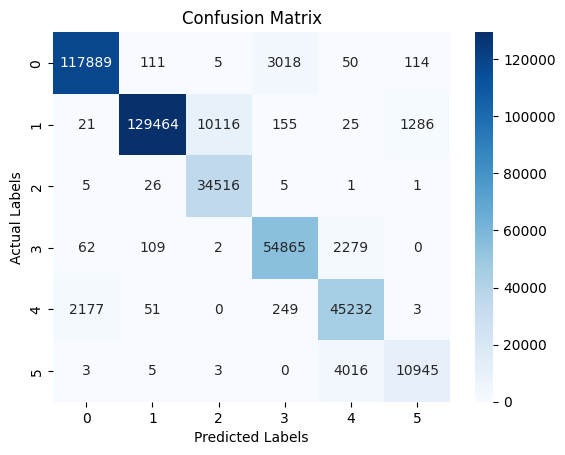

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    121187
           1       1.00      0.92      0.96    141067
           2       0.77      1.00      0.87     34554
           3       0.94      0.96      0.95     57317
           4       0.88      0.95      0.91     47712
           5       0.89      0.73      0.80     14972

    accuracy                           0.94    416809
   macro avg       0.91      0.92      0.91    416809
weighted avg       0.95      0.94      0.94    416809

Accuracy: 0.94


In [10]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

for i in tqdm(range(100), desc="Simple Progress Example"):
    time.sleep(0.1)  # Simulate some processing

# Ensure all data is tokenized similarly
all_encodings = tokenizer(list(data['text']), truncation=True, padding=True)
all_dataset = EmotionDataset(all_encodings, list(data['label']))

# Make predictions on the entire dataset
model.eval()
predictions = []
labels = []
data_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16)

for batch in tqdm(data_loader, desc="Processing batches"):
    inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
    labels.extend(batch['labels'].tolist())
    with torch.no_grad():
        outputs = model(**inputs)
        preds = outputs.logits.argmax(-1)
        predictions.extend(preds.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Calculate classification metrics
print(classification_report(labels, predictions))

# Calculate accuracy
accuracy = np.mean(np.array(predictions) == np.array(labels))
print(f"Accuracy: {accuracy:.2f}")



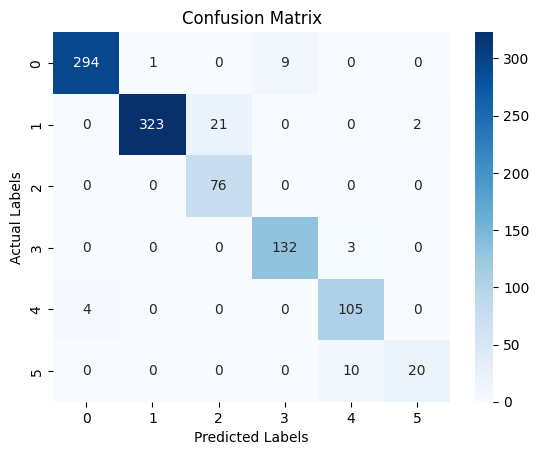

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       304
           1       1.00      0.93      0.96       346
           2       0.78      1.00      0.88        76
           3       0.94      0.98      0.96       135
           4       0.89      0.96      0.93       109
           5       0.91      0.67      0.77        30

    accuracy                           0.95      1000
   macro avg       0.92      0.92      0.91      1000
weighted avg       0.96      0.95      0.95      1000

Accuracy: 0.95


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Slice the first 1000 rows of the dataset
subset_data = data.iloc[:1000]

# Ensure the subset is tokenized similarly
subset_encodings = tokenizer(list(subset_data['text']), truncation=True, padding=True)
subset_dataset = EmotionDataset(subset_encodings, list(subset_data['label']))

# Make predictions on the subset
model.eval()
predictions = []
labels = []
for batch in torch.utils.data.DataLoader(subset_dataset, batch_size=16):
    inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
    labels.extend(batch['labels'].tolist())
    with torch.no_grad():
        outputs = model(**inputs)
        preds = outputs.logits.argmax(-1)
        predictions.extend(preds.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Calculate classification metrics
print(classification_report(labels, predictions))

# Calculate accuracy
accuracy = np.mean(np.array(predictions) == np.array(labels))
print(f"Accuracy: {accuracy:.2f}")
